In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'hate-speech-and-offensive-language-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4096079%2F7105074%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240409%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240409T095225Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daf0c40a0e23612e8ebb0fbfabcb61d2843daeba6d3cc1f3c759d78707ba6985fe05da6bcf5f766013e2f9f04c158d917b9d755768fd868fce43785d14ea107bb473d0977e91e9140f3a65f3b90b2d758c4b7337745c10bed4d5677156a3b8bfad2d04d0f06e2fa06e1e21d3d1551b2216f2323f13752c9ff06c4f583906587f5b1d54a8f93f7df65daf92c70b3c0e4eff59d09f44c4b9856ee31be44336058639416a2b5f6698a7db430b15a3eaf0aef9ce8665ce437edf1ccbb982219e3a588c791f604396eced5f7f3b9db80abb78194e6ee29b3d4e544b2770b4d1ed6322db8a4bf9b9938468f8a13e0cc585d90cc17d2ce4d86b2dcc8f42fb3f697312d51'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 986516 bytes downloaded
Downloaded and uncompressed: hate-speech-and-offensive-language-detection
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech-and-offensive-language-detection/train.csv


# Steps:
1) preprocessing
2) splitting
3) tokenize & padding
4) Create model & train
5) evaluate

# Preprocessing (cleaning the datasets):

1) remove html entity
2) change user tags (@xxx -> user)
3) remove urls
4) remove unnecessary symbol ('', !, ", ') -> cause a lot of noise in the dataset
5) remove stopwords

# 1| Import libraries

In [3]:
import pandas as pd # read the csv
import re # regex to detect username, url, html entity
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
from keras import backend as K

# 2| read the data

In [4]:
data = pd.read_csv("/kaggle/input/hate-speech-and-offensive-language-detection/train.csv")

data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
# dataset shape to know how many tweets in the datasets
print(f"num of tweets: {data.shape}")

# extract the text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

num of tweets: (24783, 6)


# 3| functions to clean the data

In [6]:
!pip install nltk

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
#notes : all of the function taking 1 text at a time
stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [10]:
!pip install nltk
import nltk

nltk.download('punkt')

# call the cleaning function
clean_tweet = preprocess(tweet)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [12]:
# call the cleaning function
clean_tweet = preprocess(tweet)

# 4| Splitting the dataset into test and validation

In [13]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)

In [14]:
## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [15]:
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [16]:
# create hot_labels (idk whty tapi ini penting, kalo ga bakal error)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [17]:
# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


# 5| Building the model

In [18]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [19]:
# change dis if u want
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

In [20]:
# checking the model parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 200)           3734200   
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3810747 (14.54 MB)
Trainable params: 38107

In [21]:
# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
310/310 [==============================] - 42s 113ms/step - loss: 0.4586 - accuracy: 0.8428 - f1: 0.8211 - precision: 0.8517 - recall: 0.7954 - val_loss: 0.3414 - val_accuracy: 0.8846 - val_f1: 0.8841 - val_precision: 0.8968 - val_recall: 0.8719
Epoch 2/10
310/310 [==============================] - 34s 110ms/step - loss: 0.2403 - accuracy: 0.9204 - f1: 0.9198 - precision: 0.9322 - recall: 0.9079 - val_loss: 0.3179 - val_accuracy: 0.8907 - val_f1: 0.8906 - val_precision: 0.8991 - val_recall: 0.8825
Epoch 3/10
310/310 [==============================] - 43s 139ms/step - loss: 0.1496 - accuracy: 0.9479 - f1: 0.9474 - precision: 0.9511 - recall: 0.9438 - val_loss: 0.4020 - val_accuracy: 0.8812 - val_f1: 0.8818 - val_precision: 0.8869 - val_recall: 0.8769
Epoch 4/10
310/310 [==============================] - 35s 111ms/step - loss: 0.1050 - accuracy: 0.9647 - f1: 0.9645 - precision: 0.9658 - recall: 0.9632 - val_loss: 0.4635 - val_accuracy: 0.8780 - val_f1: 0.8779 - val_precision: 

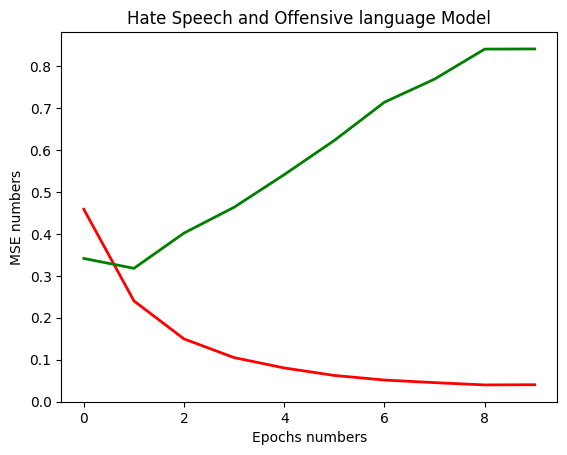

In [22]:
import matplotlib.pyplot as plt
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [23]:
from keras.models import model_from_json

# Save model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save weights to HDF5
model.save_weights("model.h5")
print("Model saved to disk.")


Model saved to disk.


In [24]:
from google.colab import files

# Download model files
files.download('model.json')
files.download('model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>